## Bone Fracture Detection Using  HBFMID (Human Bone Fracture Multi-modal Image Dataset)

Human Bone Fractures Multi-modal Image Dataset (HBFMID) consists of X-ray and MRI images including the elbow, ﬁnger, forearm, humerus, shoulder, femur, shinbone, knee, hipbone, wrist, spinal cord, and some of the healthy bones. The dataset primarily used 641 raw images, including 510 for X-ray and 131 for MRI images.It was published on 2 December 2024 by Shahnaj Parvin

Citation: Parvin, Shahnaj (2024), “Human Bone Fractures Multi-modal Image Dataset (HBFMID)”, Mendeley Data, V1, doi: 10.17632/xwfs6xbk47.1

## Importing necessary libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore, BayesianEstimator
from pgmpy.inference import VariableElimination
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [2]:
IMAGE_SIZE = (128, 128)
DATASET_DIR = "Bone_Fractures_Detection"  
CLASSES = ['Comminuted', 'Greenstick', 'Healthy', 'Linear', 'Oblique Displaced',
           'Oblique', 'Segmental', 'Spiral', 'Transverse Displaced', 'Transverse']
metrics_dict = {}

## Loading the dataset

In [3]:
def load_images_from_folder(image_folder, label_folder):
    X, y = [], []
    image_files = sorted(os.listdir(image_folder))
    label_files = sorted(os.listdir(label_folder))
    
    for img_file, lbl_file in zip(image_files, label_files):
        img_path = os.path.join(image_folder, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        
        lbl_path = os.path.join(label_folder, lbl_file)
        with open(lbl_path, 'r') as f:
            lines = f.readlines()
            if len(lines) == 0:
                continue  # skip images without labels
            class_id = int(lines[0].split()[0])
        
        X.append(img)
        y.append(class_id)
    
    return np.array(X), np.array(y)


In [4]:
print("Loading dataset...")

X_train, y_train = load_images_from_folder(
    os.path.join(DATASET_DIR, "train/images"),
    os.path.join(DATASET_DIR, "train/labels")
)
X_val, y_val = load_images_from_folder(
    os.path.join(DATASET_DIR, "valid/images"),
    os.path.join(DATASET_DIR, "valid/labels")
)
X_test, y_test = load_images_from_folder(
    os.path.join(DATASET_DIR, "test/images"),
    os.path.join(DATASET_DIR, "test/labels")
)

print(f"Loaded {len(X_train)} training, {len(X_val)} validation, {len(X_test)} testing samples")

Loading dataset...
Loaded 1344 training, 128 validation, 64 testing samples


## Extracting HOG (Histogram of Oriented Gradients) features

Histogram of Oriented Gradients (HOG) features are a powerful technique used in computer vision and image processing for object detection and recognition. The method captures the distribution of edge orientations within an image by dividing it into small, localized regions called cells.

In [5]:
def extract_hog_features(images):
    features = []
    for img in images:
        hog_feat = hog(img, pixels_per_cell=(16,16), cells_per_block=(2,2), feature_vector=True)
        features.append(hog_feat)
    return np.array(features)

In [6]:
print("Extracting HOG features...")
X_train_feat = extract_hog_features(X_train)
X_val_feat = extract_hog_features(X_val)
X_test_feat = extract_hog_features(X_test)

scaler = StandardScaler()
X_train_feat = scaler.fit_transform(X_train_feat)
X_val_feat = scaler.transform(X_val_feat)
X_test_feat = scaler.transform(X_test_feat)

Extracting HOG features...


## Logistic Regression

Accuracy: 0.5938
Precision (macro): 0.6976
Recall (macro): 0.4937
F1-score (macro): 0.5502

Classification Report:
                       precision    recall  f1-score   support

          Comminuted       0.88      0.50      0.64        14
          Greenstick       0.50      0.14      0.22         7
             Healthy       1.00      0.43      0.60         7
              Linear       1.00      1.00      1.00         1
   Oblique Displaced       0.57      0.61      0.59        28
             Oblique       0.75      0.43      0.55         7
           Segmental       1.00      0.67      0.80         3
              Spiral       0.00      0.00      0.00         5
Transverse Displaced       0.53      0.83      0.65        47
          Transverse       0.75      0.33      0.46         9

            accuracy                           0.59       128
           macro avg       0.70      0.49      0.55       128
        weighted avg       0.62      0.59      0.57       128



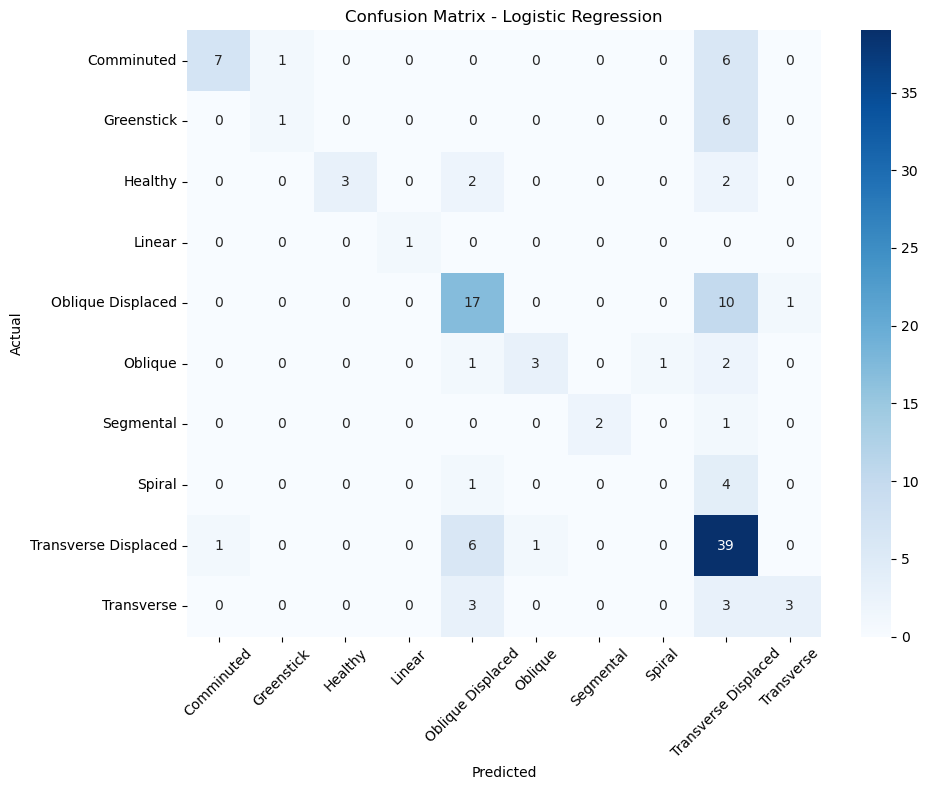

In [10]:
logreg = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
logreg.fit(X_train_feat, y_train)
y_pred = logreg.predict(X_val_feat)
y_pred = y_pred.astype(int)


acc_log = accuracy_score(y_val, y_pred)
prec_log = precision_score(y_val, y_pred, average='macro')
rec_log = recall_score(y_val, y_pred, average='macro')
f1_log = f1_score(y_val, y_pred, average='macro')

labels = list(range(len(CLASSES)))

print(f"Accuracy: {acc_log:.4f}")
print(f"Precision (macro): {prec_log:.4f}")
print(f"Recall (macro): {rec_log:.4f}")
print(f"F1-score (macro): {f1_log:.4f}")
print("\nClassification Report:\n", classification_report(
    y_val, 
    y_pred, 
    labels=labels, 
    target_names=CLASSES, 
    zero_division = 0
    ))

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

metrics_dict['Logistic Regression'] = {
    'accuracy': acc_log,
    'precision': prec_log,
    'recall': rec_log,
    'f1_score': f1_log
}

## K Nearest Neighbour and Support Vector Machine

PCA (Principal Component Analysis) is applied to reduce high-dimensional feature spaces before using SVM or KNN. For KNN, it speeds up distance computations and reduces the impact of noisy or redundant features. For SVM, it decreases the computational burden of solving the optimization problem in high-dimensional space. In both cases, PCA can also improve generalization by retaining the most informative variance and discarding irrelevant noise.

In [ ]:
   pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'pca__n_components': [0.90, 0.95, 0.99],  
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_feat, y_train)

print("Best parameters:", grid.best_params_)
print("Best cross-validation accuracy:", grid.best_score_)


KNN Validation Accuracy: 0.5859
Precision (macro): 0.7089
Recall (macro): 0.5870
F1-score (macro): 0.6226

Classification Report:
                       precision    recall  f1-score   support

          Comminuted       0.25      0.21      0.23        14
          Greenstick       0.43      0.43      0.43         7
             Healthy       0.71      0.71      0.71         7
              Linear       1.00      1.00      1.00         1
   Oblique Displaced       0.59      0.57      0.58        28
             Oblique       1.00      0.29      0.44         7
           Segmental       1.00      0.67      0.80         3
              Spiral       1.00      0.80      0.89         5
Transverse Displaced       0.60      0.74      0.67        47
          Transverse       0.50      0.44      0.47         9

            accuracy                           0.59       128
           macro avg       0.71      0.59      0.62       128
        weighted avg       0.60      0.59      0.58       128

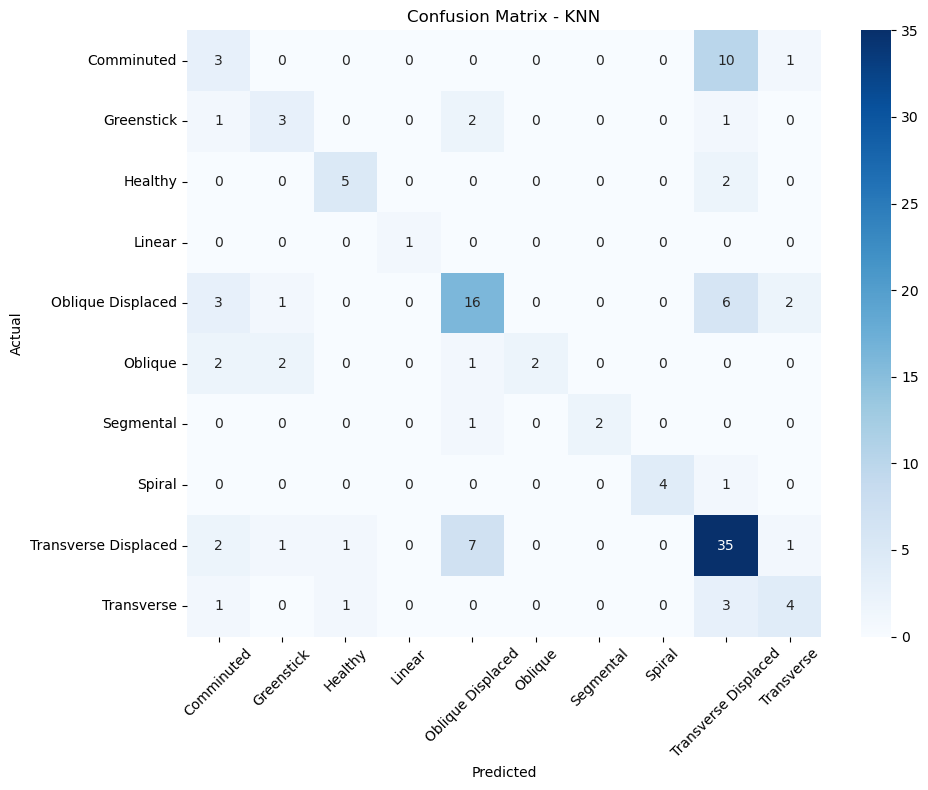

In [10]:
pca = PCA(n_components=20)  
X_train_pca = pca.fit_transform(X_train_feat)
X_val_pca = pca.transform(X_val_feat)

labels = list(range(len(CLASSES)))

knn = KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree', n_jobs=-1)
knn.fit(X_train_pca, y_train)

y_pred_knn = knn.predict(X_val_pca)
y_pred_knn = y_pred_knn.astype(int)

acc_knn = accuracy_score(y_val, y_pred_knn)
prec_knn = precision_score(y_val, y_pred_knn, average='macro')
rec_knn = recall_score(y_val, y_pred_knn, average='macro')
f1_knn = f1_score(y_val, y_pred_knn, average='macro')

print(f"KNN Validation Accuracy: {acc_knn:.4f}")
print(f"Precision (macro): {prec_knn:.4f}")
print(f"Recall (macro): {rec_knn:.4f}")
print(f"F1-score (macro): {f1_knn:.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred_knn, labels=labels, target_names=CLASSES))

cm = confusion_matrix(y_val, y_pred_knn)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - KNN")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

metrics_dict['KNN'] = {
    'accuracy': acc_knn,
    'precision': prec_knn,
    'recall': rec_knn,
    'f1_score': f1_knn
}

SVM Validation Accuracy: 0.5234
Precision (macro): 0.5804
Recall (macro): 0.3879
F1-score (macro): 0.4026

Classification Report:
                       precision    recall  f1-score   support

          Comminuted       0.00      0.00      0.00        14
          Greenstick       0.00      0.00      0.00         7
             Healthy       0.75      0.43      0.55         7
              Linear       1.00      1.00      1.00         1
   Oblique Displaced       0.59      0.68      0.63        28
             Oblique       1.00      0.14      0.25         7
           Segmental       1.00      0.67      0.80         3
              Spiral       0.00      0.00      0.00         5
Transverse Displaced       0.46      0.85      0.60        47
          Transverse       1.00      0.11      0.20         9

            accuracy                           0.52       128
           macro avg       0.58      0.39      0.40       128
        weighted avg       0.50      0.52      0.44       128

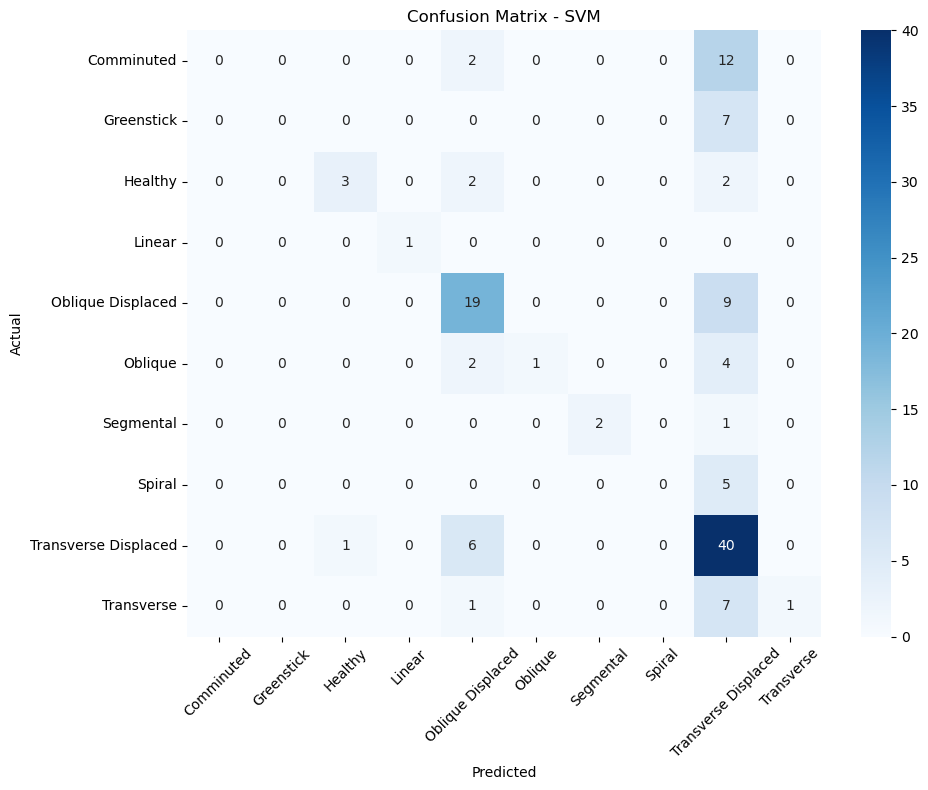

In [12]:
svm = SVC(kernel='rbf', probability=True)
svm.fit(X_train_pca, y_train)

y_pred_svm = svm.predict(X_val_pca)
y_pred_svm = y_pred_svm.astype(int)

acc_svm = accuracy_score(y_val, y_pred_svm)
prec_svm = precision_score(y_val, y_pred_svm, average='macro')
rec_svm = recall_score(y_val, y_pred_svm, average='macro')
f1_svm = f1_score(y_val, y_pred_svm, average='macro')

print(f"SVM Validation Accuracy: {acc_svm:.4f}")
print(f"Precision (macro): {prec_svm:.4f}")
print(f"Recall (macro): {rec_svm:.4f}")
print(f"F1-score (macro): {f1_svm:.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred_svm, labels=labels, target_names=CLASSES))


cm = confusion_matrix(y_val, y_pred_svm)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

metrics_dict['SVM'] = {
    'accuracy': acc_svm,
    'precision': prec_svm,
    'recall': rec_svm,
    'f1_score': f1_svm
}

## Naive Bayes Classifier

Naive Bayes Validation Accuracy: 0.3984
Precision (macro): 0.3621
Recall (macro): 0.2892
F1-score (macro): 0.3048

Classification Report:
                       precision    recall  f1-score   support

          Comminuted       0.47      0.57      0.52        14
          Greenstick       0.20      0.14      0.17         7
             Healthy       0.60      0.43      0.50         7
              Linear       0.00      0.00      0.00         1
   Oblique Displaced       0.38      0.54      0.44        28
             Oblique       0.17      0.14      0.15         7
           Segmental       1.00      0.33      0.50         3
              Spiral       0.00      0.00      0.00         5
Transverse Displaced       0.47      0.40      0.44        47
          Transverse       0.33      0.33      0.33         9

            accuracy                           0.40       128
           macro avg       0.36      0.29      0.30       128
        weighted avg       0.41      0.40      0.39  

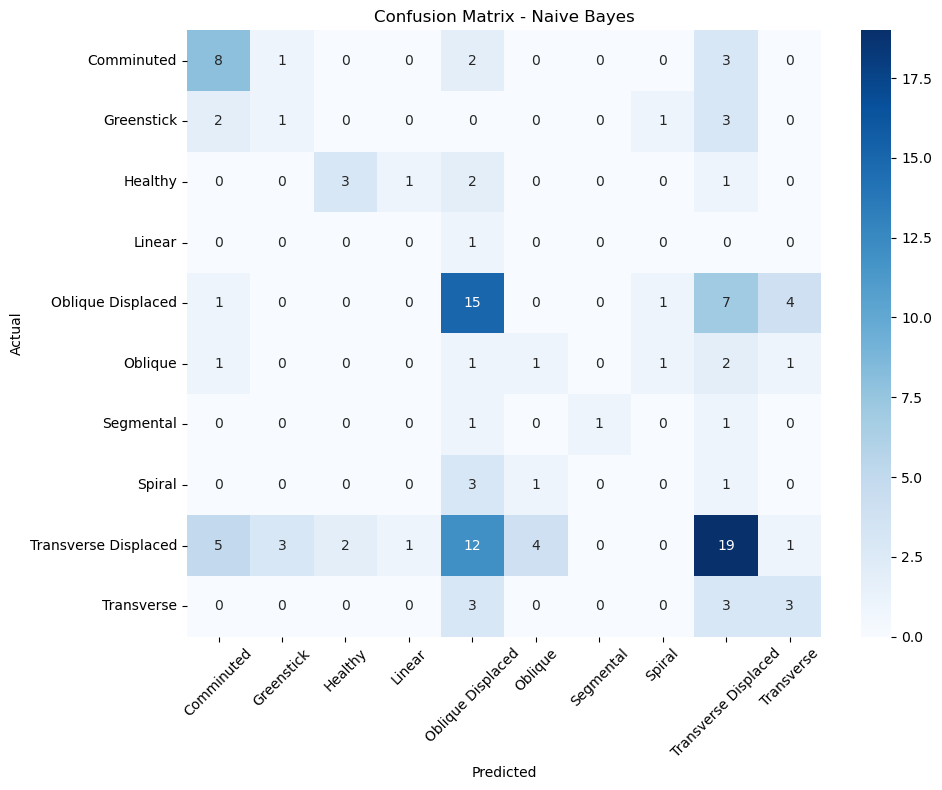

In [13]:
nb = GaussianNB()
nb.fit(X_train_feat, y_train)


y_pred_nb = nb.predict(X_val_feat)
y_pred_nb = y_pred_nb.astype(int)

acc_nb = accuracy_score(y_val, y_pred_nb)
prec_nb = precision_score(y_val, y_pred_nb, average='macro')
rec_nb = recall_score(y_val, y_pred_nb, average='macro')
f1_nb = f1_score(y_val, y_pred_nb, average='macro')

print(f"Naive Bayes Validation Accuracy: {acc_nb:.4f}")
print(f"Precision (macro): {prec_nb:.4f}")
print(f"Recall (macro): {rec_nb:.4f}")
print(f"F1-score (macro): {f1_nb:.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred_nb,labels=labels, target_names=CLASSES))


cm = confusion_matrix(y_val, y_pred_nb)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Naive Bayes")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

metrics_dict['Naive Bayes'] = {
    'accuracy': acc_nb,
    'precision': prec_nb,
    'recall': rec_nb,
    'f1_score': f1_nb
}

## Bayesian Network

Selected features for BN: ['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6', 'feat_7', 'feat_8', 'feat_9']
Estimating Bayesian Network structure...


  0%|          | 0/50 [00:00<?, ?it/s]

Learned BN edges: [('feat_0', 'feat_9'), ('feat_1', 'feat_0'), ('feat_2', 'feat_9'), ('feat_2', 'feat_1'), ('feat_2', 'feat_0'), ('feat_3', 'feat_4'), ('feat_3', 'feat_2'), ('feat_4', 'feat_9'), ('feat_4', 'feat_0'), ('feat_5', 'feat_7'), ('feat_5', 'feat_3'), ('feat_7', 'feat_1'), ('feat_7', 'feat_3'), ('feat_7', 'feat_2'), ('feat_6', 'feat_5'), ('feat_6', 'feat_2'), ('feat_6', 'feat_7'), ('feat_6', 'feat_4')]

Bayesian Network Accuracy: 0.1172
Precision (macro): 0.1297
Recall (macro): 0.1358
F1-score (macro): 0.1152

Classification Report:
                       precision    recall  f1-score   support

          Comminuted       0.25      0.21      0.23        14
          Greenstick       0.17      0.29      0.21         7
             Healthy       0.06      0.14      0.08         7
              Linear       0.00      0.00      0.00         1
   Oblique Displaced       0.23      0.11      0.15        28
             Oblique       0.10      0.14      0.12         7
           Segme

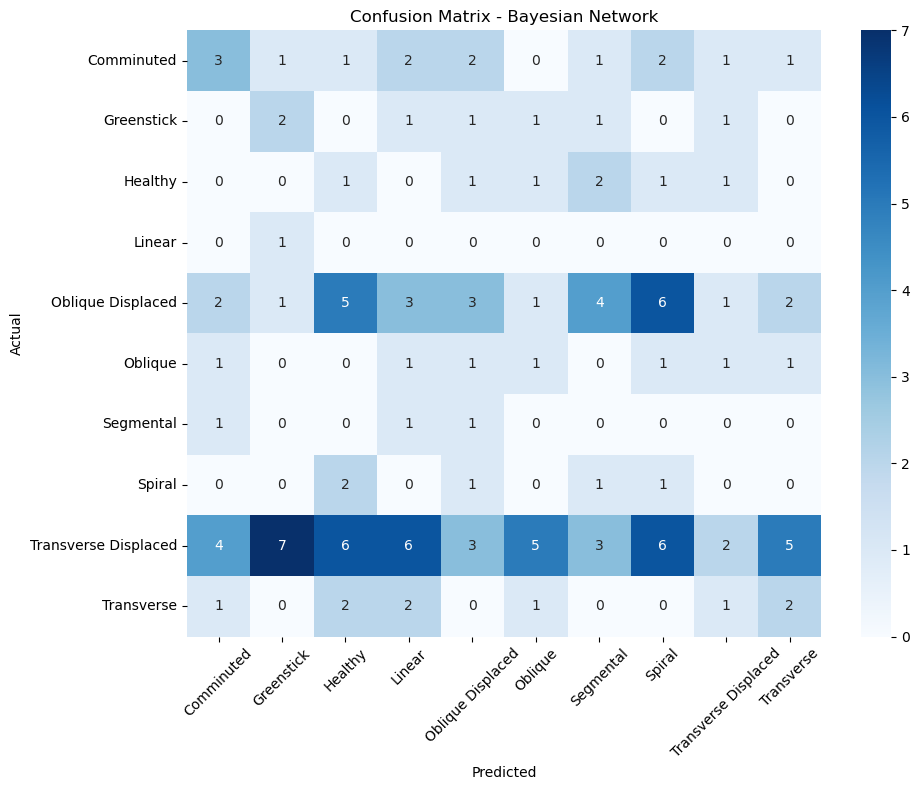

In [23]:
selected_features = [f"feat_{i}" for i in range(10)]
print(f"Selected features for BN: {selected_features}")

train_small = pd.DataFrame(X_train_feat, columns=[f'feat_{i}' for i in range(X_train_feat.shape[1])])[selected_features]
train_small['target'] = y_train 

val_small = pd.DataFrame(X_val_feat, columns=[f'feat_{i}' for i in range(X_val_feat.shape[1])])[selected_features]
val_small['target'] = y_val 



n_bins = 5  
disc = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')

train_disc = disc.fit_transform(train_small[selected_features])
val_disc = disc.transform(val_small[selected_features])

train_small_discrete = train_small.copy()
val_small_discrete = val_small.copy()

for i, col in enumerate(selected_features):
    train_small_discrete[col] = train_disc[:, i].astype(int)
    val_small_discrete[col] = val_disc[:, i].astype(int)

print("Estimating Bayesian Network structure...")
hc = HillClimbSearch(train_small_discrete)
best_model = hc.estimate(
    scoring_method=BicScore(train_small_discrete),
    max_indegree=3,
    max_iter=50
)

bn_model = BayesianNetwork(best_model.edges())
print("Learned BN edges:", bn_model.edges())

bn_model.fit(train_small_discrete, estimator=BayesianEstimator, prior_type="BDeu")
infer = VariableElimination(bn_model)

def predict_bn(model, df):
    preds = []
    model_nodes = set(model.variables)
    for _, row in df.iterrows():
        evidence = {k: v for k, v in row.items() if k in model_nodes and k != 'target'}
        try:
            q = model.map_query(variables=['target'], evidence=evidence)
            preds.append(q['target'])
        except Exception:
            preds.append(np.random.choice(df['target'].unique()))  # fallback prediction
    return np.array(preds)


y_pred_bn = predict_bn(infer, val_small_discrete)

acc_bn = accuracy_score(y_val, y_pred_bn)
prec_bn = precision_score(y_val, y_pred_bn, average='macro')
rec_bn = recall_score(y_val, y_pred_bn, average='macro')
f1_bn = f1_score(y_val, y_pred_bn, average='macro')

print(f"\nBayesian Network Accuracy: {acc_bn:.4f}")
print(f"Precision (macro): {prec_bn:.4f}")
print(f"Recall (macro): {rec_bn:.4f}")
print(f"F1-score (macro): {f1_bn:.4f}")

print("\nClassification Report:\n", classification_report(y_val, y_pred_bn, target_names=CLASSES))


cm = confusion_matrix(y_val, y_pred_bn)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Bayesian Network")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


metrics_dict['Bayesian Network'] = {
    'accuracy': acc_bn,
    'precision': prec_bn,
    'recall': rec_bn,
    'f1_score': f1_bn
}

## Decision Tree Classifier

Decision Tree Accuracy: 0.3125
Precision (macro): 0.2072
Recall (macro): 0.2454
F1-score (macro): 0.2167

Classification Report:
                       precision    recall  f1-score   support

          Comminuted       0.45      0.36      0.40        14
          Greenstick       0.00      0.00      0.00         7
             Healthy       0.17      0.14      0.15         7
              Linear       0.50      1.00      0.67         1
   Oblique Displaced       0.30      0.32      0.31        28
             Oblique       0.20      0.14      0.17         7
           Segmental       0.00      0.00      0.00         3
              Spiral       0.00      0.00      0.00         5
Transverse Displaced       0.45      0.49      0.47        47
          Transverse       0.00      0.00      0.00         9

            accuracy                           0.31       128
           macro avg       0.21      0.25      0.22       128
        weighted avg       0.30      0.31      0.31       128


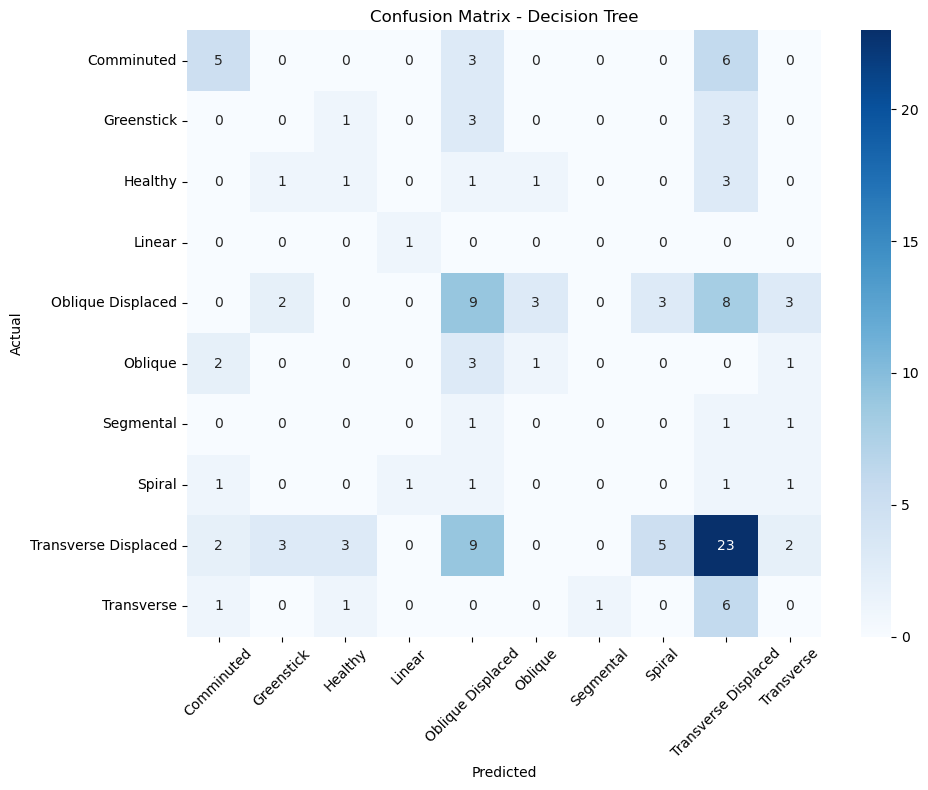

In [24]:
dt_model = DecisionTreeClassifier(random_state=42)

dt_model.fit(X_train_feat, y_train)

y_pred_dt = dt_model.predict(X_val_feat)

acc_dt = accuracy_score(y_val, y_pred_dt)
prec_dt = precision_score(y_val, y_pred_dt, average='macro')
rec_dt = recall_score(y_val, y_pred_dt, average='macro')
f1_dt = f1_score(y_val, y_pred_dt, average='macro')

print(f"Decision Tree Accuracy: {acc_dt:.4f}")
print(f"Precision (macro): {prec_dt:.4f}")
print(f"Recall (macro): {rec_dt:.4f}")
print(f"F1-score (macro): {f1_dt:.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred_dt, target_names=CLASSES))

cm = confusion_matrix(y_val, y_pred_dt)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Decision Tree")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

metrics_dict['Decision Tree'] = {
    'accuracy': acc_dt,
    'precision': prec_dt,
    'recall': rec_dt,
    'f1_score': f1_dt
}

## Random Forest Classifier

Random Forest Accuracy: 0.4297
Precision (macro): 0.1011
Recall (macro): 0.1329
F1-score (macro): 0.1039

Classification Report:
                       precision    recall  f1-score   support

          Comminuted       0.00      0.00      0.00        14
          Greenstick       0.00      0.00      0.00         7
             Healthy       0.00      0.00      0.00         7
              Linear       0.00      0.00      0.00         1
   Oblique Displaced       0.61      0.39      0.48        28
             Oblique       0.00      0.00      0.00         7
           Segmental       0.00      0.00      0.00         3
              Spiral       0.00      0.00      0.00         5
Transverse Displaced       0.40      0.94      0.56        47
          Transverse       0.00      0.00      0.00         9

            accuracy                           0.43       128
           macro avg       0.10      0.13      0.10       128
        weighted avg       0.28      0.43      0.31       128


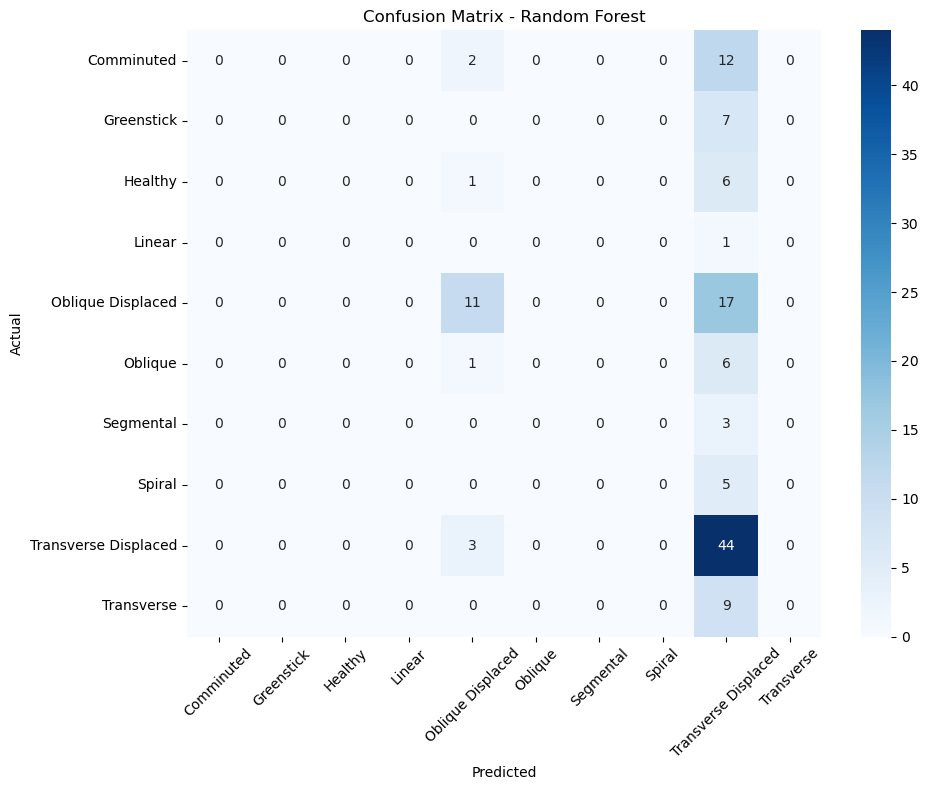

In [7]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train_feat, y_train)

y_pred_rf = rf_model.predict(X_val_feat)

acc_rf = accuracy_score(y_val, y_pred_rf)
prec_rf = precision_score(y_val, y_pred_rf, average='macro')
rec_rf = recall_score(y_val, y_pred_rf, average='macro')
f1_rf = f1_score(y_val, y_pred_rf, average='macro')

print(f"Random Forest Accuracy: {acc_rf:.4f}")
print(f"Precision (macro): {prec_rf:.4f}")
print(f"Recall (macro): {rec_rf:.4f}")
print(f"F1-score (macro): {f1_rf:.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred_rf, target_names=CLASSES))

cm = confusion_matrix(y_val, y_pred_rf)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

metrics_dict['Random Forest'] = {
    'accuracy': acc_rf,
    'precision': prec_rf,
    'recall': rec_rf,
    'f1_score': f1_rf
}


## XGBoost Classifier

XGBoost Accuracy: 0.4609
Precision (macro): 0.4895
Recall (macro): 0.1862
F1-score (macro): 0.1978

Classification Report:
                       precision    recall  f1-score   support

          Comminuted       1.00      0.14      0.25        14
          Greenstick       0.00      0.00      0.00         7
             Healthy       1.00      0.14      0.25         7
              Linear       0.00      0.00      0.00         1
   Oblique Displaced       0.46      0.43      0.44        28
             Oblique       1.00      0.14      0.25         7
           Segmental       0.00      0.00      0.00         3
              Spiral       0.00      0.00      0.00         5
Transverse Displaced       0.43      0.89      0.58        47
          Transverse       1.00      0.11      0.20         9

            accuracy                           0.46       128
           macro avg       0.49      0.19      0.20       128
        weighted avg       0.55      0.46      0.38       128



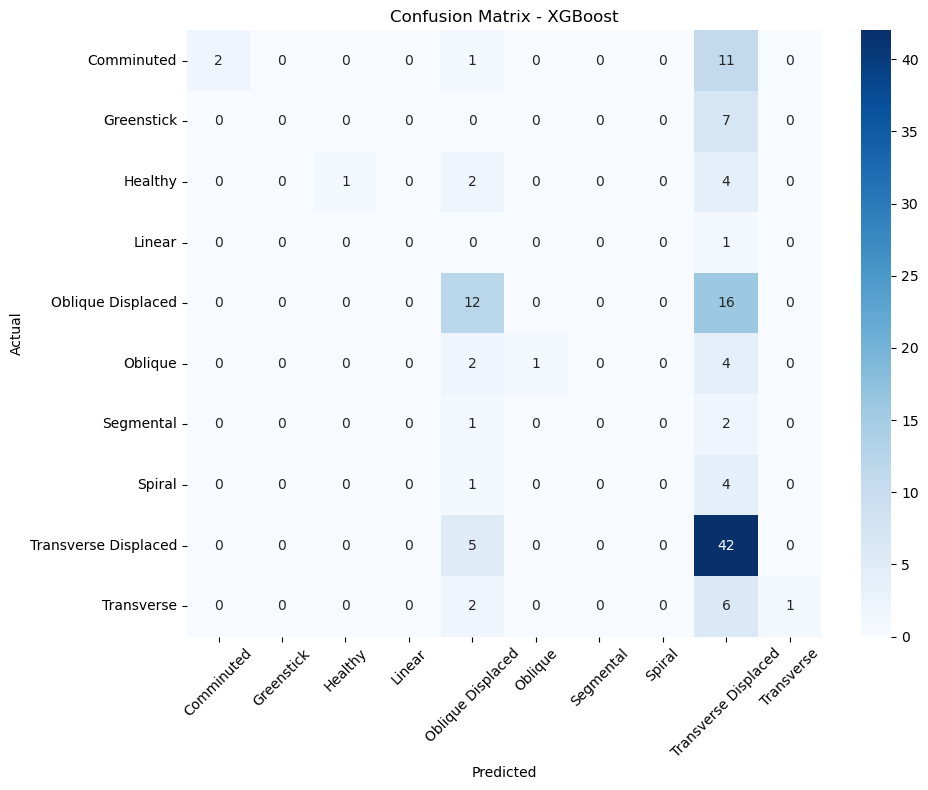

In [8]:
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, use_label_encoder=False, eval_metric='mlogloss', random_state=42)

xgb_model.fit(X_train_feat, y_train)

y_pred_xgb = xgb_model.predict(X_val_feat)

acc_xgb = accuracy_score(y_val, y_pred_xgb)
prec_xgb = precision_score(y_val, y_pred_xgb, average='macro')
rec_xgb = recall_score(y_val, y_pred_xgb, average='macro')
f1_xgb = f1_score(y_val, y_pred_xgb, average='macro')

print(f"XGBoost Accuracy: {acc_xgb:.4f}")
print(f"Precision (macro): {prec_xgb:.4f}")
print(f"Recall (macro): {rec_xgb:.4f}")
print(f"F1-score (macro): {f1_xgb:.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred_xgb, target_names=CLASSES))

cm = confusion_matrix(y_val, y_pred_xgb)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

metrics_dict['XGBoost'] = {
    'accuracy': acc_xgb,
    'precision': prec_xgb,
    'recall': rec_xgb,
    'f1_score': f1_xgb
}


## AdaBoost Classifier

In [ ]:
adb_model = AdaBoostClassifier(n_estimators=100, learning_rate=1.0, random_state=42)

adb_model.fit(X_train_feat, y_train)

y_pred_adb = adb_model.predict(X_val_feat)

acc_adb = accuracy_score(y_val, y_pred_adb)
prec_adb = precision_score(y_val, y_pred_adb, average='macro')
rec_adb = recall_score(y_val, y_pred_adb, average='macro')
f1_adb = f1_score(y_val, y_pred_adb, average='macro')

print(f"AdaBoost Accuracy: {acc_adb:.4f}")
print(f"Precision (macro): {prec_adb:.4f}")
print(f"Recall (macro): {rec_adb:.4f}")
print(f"F1-score (macro): {f1_adb:.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred_adb, target_names=CLASSES))

cm = confusion_matrix(y_val, y_pred_adb)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - AdaBoost")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

metrics_dict['AdaBoost'] = {
    'accuracy': acc_adb,
    'precision': prec_adb,
    'recall': rec_adb,
    'f1_score': f1_adb
}


## Multilayer Perceptron

In [ ]:
mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 64),   
    activation='relu',              
    solver='adam',                  
    alpha=1e-4,                     
    learning_rate='adaptive',       
    max_iter=300,                   
    random_state=42
)

mlp_model.fit(X_train_feat, y_train)

y_pred_mlp = mlp_model.predict(X_val_feat)

acc_mlp = accuracy_score(y_val, y_pred_mlp)
prec_mlp = precision_score(y_val, y_pred_mlp, average='macro')
rec_mlp = recall_score(y_val, y_pred_mlp, average='macro')
f1_mlp = f1_score(y_val, y_pred_mlp, average='macro')

print(f"MLP Accuracy: {acc_mlp:.4f}")
print(f"Precision (macro): {prec_mlp:.4f}")
print(f"Recall (macro): {rec_mlp:.4f}")
print(f"F1-score (macro): {f1_mlp:.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred_mlp, target_names=CLASSES))

cm = confusion_matrix(y_val, y_pred_mlp)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - MLP Classifier")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

metrics_dict['MLP'] = {
    'accuracy': acc_mlp,
    'precision': prec_mlp,
    'recall': rec_mlp,
    'f1_score': f1_mlp